# reduced classes experiments for entropy labelling

In [30]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
import time
from numpy.random import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [31]:
def randints_nodup(k):
    ns = []
    while (len(ns) < k):
        n = randint(0, 10)
        if not n in ns:
            ns.append(n)
    return list(ns) 

In [32]:
# entropy labelling
def ent_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    # クラス数変えると，probaでのindexがそのままlabelとして使えないのでs_cls内を参照させる
    labels = np.array([s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp])
    
    return labels

In [33]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = len(labels)
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup

In [20]:
# 乱数でクラスを選ぶ
def entropy_scls_learning(classes_num):
    # sortされてないとpredict_probaとるときに整合性とれなくなる
    s_cls = randints_nodup(classes_num)
    # sort()は破壊的変更を行うだけで，sortされたlistそのものが返ってくるのではない
    s_cls.sort()

    # 選ばれたクラスだけのデータとラベルを用意
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    #print(f"{classes_num} classes learning: {s_cls}")
    model = LR().fit(trn_imgs[orig_A1:orig_A1 + lim_A1], trn_labels[orig_A1:orig_A1 + lim_A1])
    acc = accuracy_score(tst_labels, model.predict(tst_imgs))
    #print(f"learnt with original labels: {acc*100}[%]")

    # 2クラスの場合，選ばれたクラス次第では，というかほとんどの組み合わせでdiv by 0になってしまうらしい
    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A1], trn_labels[:orig_A1])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A1:orig_A1 + lim_A1])

    # entropy labelling
    mul_labels = [ent_label(probas, s_cls) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(trn_imgs[orig_A1:orig_A1 + lim_A1])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
    #print(f"entropy labelled learning: {acc*100}[%]")
    return acc*100

## MNIST

In [34]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

orig_A1 = 2000
lim_A1 = 2000

In [21]:
results = np.array([np.average([entropy_scls_learning(j) for _ in range(10)]) for j in range(2, 11)])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-package

In [22]:
results

array([98.32573972, 96.22298431, 94.10679996, 90.9174918 , 89.45032077,
       86.26696993, 85.75903625, 84.47116918, 81.68      ])

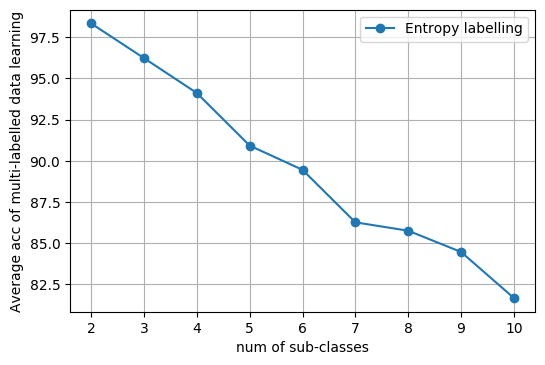

In [29]:
plt.figure(dpi = 100)
plt.plot([i for i in range(2, 11)], results, marker = "o", label = "Entropy labelling")
plt.xlabel("num of sub-classes")
plt.ylabel("Average acc of multi-labelled data learning")	
plt.legend(loc = "upper right")
plt.grid(True)

## CIFAR 10

In [35]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

orig_A2 = 2000
lim_A2 = 2000

In [36]:
results2 = np.array([np.average([entropy_scls_learning(j) for _ in range(10)]) for j in range(2, 11)])

KeyboardInterrupt: 

## CIFAR100

In [17]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode = "fine")

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

orig_A3 = 200
lim_A3 = 200

5 classes learning: [2, 3, 4, 7, 8]


In [ ]:
results3 = np.array([np.average([entropy_scls_learning(j) for _ in range(10)]) for j in range(2, 11)])